In [61]:
import pickle as pkl
import numpy as np
import os
import nilearn
from nilearn.image import load_img
from nilearn import plotting
import matplotlib
%matplotlib inline
import pickle as pkl

In [62]:
# Some visualization
# root = '/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/'
# t1_eval_dir='eval_out18_t1/'
# t2_eval_dir='eval_out18_t2/'
# pred = 'Brats18_2013_10_1.nii.gz'
# t1_seg_pred = load_img(root + t1_eval_dir + pred)
# t2_seg_pred = load_img(root + t2_eval_dir + pred)
# print(t1_seg_pred.shape, t2_seg_pred.shape)
# plotting.plot_roi(t1_seg_pred) # brain data
# plotting.plot_roi(t2_seg_pred) # brain data

In [329]:
# Load data
def load_data():
    root = '/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/'
    t1_predict_dir = 'eval_out18_t1/'
    t2_predict_dir = 'eval_out18_t2/'
    

    base_dir = '/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/'
    t1_prob_dir ='eval_out18_t1_prob_False/'
    t2_prob_dir ='eval_out18_t2_prob_False/'
    seg_dir = '/home/nfs/zpy/testing_dic/544proj/data/val_t1/'
    
    
    t1_logits = []
    t2_logits = []
    gts = []
    for i in os.listdir(root+t1_prob_dir):
        with open(root + t1_prob_dir + i, 'rb') as f :
            t1 = pkl.load(open(root + t1_prob_dir + i, 'rb')) # 155, 240, 240, 4
        f.close()
        with open(root + t2_prob_dir + i, 'rb') as f :
            t2 = pkl.load(f)
        f.close()
        
        t1_logits.append(np.transpose(t1,[1,2,0,3]))
        t2_logits.append(np.transpose(t2,[1,2,0,3]))
        seg_name = i.replace('.pkl', '_seg.nii.gz')
        seg_real = load_img(seg_dir + i.split('.')[0] +'/' + seg_name).get_data()
        gts.append(seg_real)
    t1_evals = []
    t2_evals = []
    filenames = os.listdir(root+t1_predict_dir)
    
    for i in filenames:
        t1_seg_pred = load_img(root + t1_predict_dir + i).get_data()
        t2_seg_pred = load_img(root + t2_predict_dir + i).get_data()
        
        t1_evals.append(t1_seg_pred)
        t2_evals.append(t2_seg_pred)
        
    print("Loading done")
    return t1_logits, t2_logits, gts, t1_evals, t2_evals


In [348]:
def cal_acc(pred, seg):
    denominator = pred.shape[0] *  pred.shape[1] * pred.shape[2] 
    # from prob
    # Pred (155, 240, 240)
    # Seg  (240, 240, 155)
    
    return np.sum(pred == seg)/denominator

def evaluate(preds_list, segs_list):
    acc = []
    for i in range(len(preds_list)):
        acc.append(cal_acc(preds_list[i], segs_list[i]))
    print('Mean acc: %.4f'%np.mean(acc))

# Well, in the competation they seem to compute for each class. I used it improper.
def binary_dice3d(ss,gs):
    """
    dice score of 3d binary volumes
    inputs: 
        ss: segmentation volume
        gs: ground truth volume
    outputs:
        dice: the dice score
    """
    dices = []
    for i in range(len(ss)):
        s = ss[i]
        g = gs[i]
        
        assert(len(s.shape)==3)
        [Ds, Hs, Ws] = s.shape
        [Dg, Hg, Wg] = g.shape
        assert(Ds==Dg and Hs==Hg and Ws==Wg)
        prod = np.multiply(s, g)
        s0 = prod.sum()
        s1 = s.sum()
        s2 = g.sum()
        dice = (2.0*s0 + 1e-10)/(s1 + s2 + 1e-10)
        dices.append(dice)
    avg_dice = np.mean(dices)
    print('Avg_dice: %.4f '%avg_dice)
    return avg_dice

# Safe_log
def safe_log(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))

# Naive Bayes
def predict_best(t1_logits, t2_logits, prior):
    best_preds = []
    for i in range(len(t1_logits)):
        
        probs = []
        for class_ in range(t1_logits[0].shape[-1]):
            probs.append(safe_log(prior[class_]) + 
                         safe_log(t1_logits[i][:,:,:, class_]) + 
                         safe_log(t2_logits[i][:,:,:,class_]))
            
        stack = np.stack(probs, axis=-1) # 155, 240, 240, 4 
        nb_pred = np.argmax(stack, axis=-1) # -> 155, 240, 240
        best_preds.append(nb_pred) 
    return best_preds

# Compute prior
def compute_prior(gts): 
    prior = [0, 0, 0, 0]
    classes = [0, 1, 2, 4]
    for i in range(len(t1_logits)):
        for i, class_ in enumerate(classes):
            prior[i] += np.sum(gts[i] == class_)
    norm_prior = prior/sum(prior)
    print(norm_prior)
    return norm_prior

In [331]:
# Load data
t1_logits, t2_logits, gts, t1_evals, t2_evals = load_data()

/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: ResourceWarning: unclosed file <_io.BufferedReader name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_t1_prob_False/Brats18_2013_10_1.pkl'>
/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: ResourceWarning: unclosed file <_io.BufferedReader name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_t1_prob_False/Brats18_2013_11_1.pkl'>
/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: ResourceWarning: unclosed file <_io.BufferedReader name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_t1_prob_False/Brats18_2013_12_1.pkl'>
/home/nf

Loading done


In [337]:
norm_prior = compute_prior(gts)

[9.79564454e-01 5.09310904e-03 1.48461145e-02 4.96322304e-04]


In [332]:
# Apply Naive Bayes
# Since we don't use the original logits, I don't fix here.
# [Not done!] One problem is that we should change the logit values of [0,0,0,0] to [1,0,0,0]
nb_preds = predict_best(t1_logits, t2_logits, prior=norm_prior)

In [333]:
# Some evaluations on original data (240, 240, 155)
evaluate(t1_evals, gts)
evaluate(t2_evals, gts)
evaluate(nb_preds, gts) 

binary_dice3d(t1_evals, gts)
binary_dice3d(t2_evals, gts)
binary_dice3d(nb_preds, gts)

Mean acc: 0.9938
Mean acc: 0.9899
Mean acc: 0.9796
Avg_dice: 2.0211 
Avg_dice: 1.3889 
Avg_dice: 0.2255 


0.2254965386480981

In [334]:
# Crop logits and gt
from utils import *
def get_none_zero_region(im, margin):
    """
    get the bounding box of the non-zero region of an ND volume
    """
    input_shape = im.shape
    if(type(margin) is int ):
        margin = [margin]*len(input_shape)
    assert(len(input_shape) == len(margin))
    indxes = np.nonzero(im)
    idx_min = []
    idx_max = []
    for i in range(len(input_shape)):
        idx_min.append(indxes[i].min())
        idx_max.append(indxes[i].max())

    for i in range(len(input_shape)):
        idx_min[i] = max(idx_min[i] - margin[i], 0)
        idx_max[i] = min(idx_max[i] + margin[i], input_shape[i] - 1)
    return idx_min, idx_max

def padding_gt(gt_volume, max_coor):
    volume = np.zeros(max_coor)
    sp = gt_volume.shape
    # print('gt', sp, volume.shape)
    volume[:sp[0], :sp[1], :sp[2]] = gt_volume
    return volume

def padding_prob(prob_volume, max_coor):
    volume = np.zeros(max_coor+[4])
    sp = prob_volume.shape
    # print('shape sp, volume', sp, volume.shape)
    volume[:sp[0], :sp[1], :sp[2], :sp[3]] = prob_volume
    volume[sp[0]:, sp[1]:, sp[2]:, 0] = 1
    sum_ = np.sum(volume,axis=-1)
    volume[sum_ == 0,0]=1
    sum_ = np.sum(volume,axis=-1)
    assert np.sum(sum_==0)==0
    return volume
    
def prob_crop(volume, min_idx, max_idx):
    output = volume[min_idx[0]: max_idx[0] + 1,
                    min_idx[1]: max_idx[1] + 1,
                    min_idx[2]: max_idx[2] + 1,
                    :]
    return output
def crop_seg_and_prob(probs, gts):
    max_coor = [0, 0, 0]
    gt_volumes = []
    prob_volumes = []
    for i in range(len(gts)):
        bbmin, bbmax = get_none_zero_region(gts[i], 5)
        gt_volume = crop_ND_volume_with_bounding_box(gts[i], bbmin, bbmax)
        
        
        transposed_prob = np.transpose(probs[i], (1,2,0,3))
        #print(i, gts[i].shape, probs[i].shape, transposed_prob.shape)
        
        
        #prob_volume = crop_ND_volume_with_bounding_box(transposed_prob, bbmin, bbmax)
        prob_volume = prob_crop(probs[i], bbmin, bbmax)
        
        gt_volumes.append(gt_volume)
        prob_volumes.append(prob_volume)
        
        if(gt_volume.shape[0] > max_coor[0]):
            max_coor[0] = gt_volume.shape[0]
        if(gt_volume.shape[1] > max_coor[1]):
            max_coor[1] = gt_volume.shape[1]
        if(gt_volume.shape[2] > max_coor[2]):
            max_coor[2] = gt_volume.shape[2]
    
    padding_gt_volumes = []
    padding_prob_volumes = []
    
    for i in range(len(gts)):
        padding_gt_volumes.append(padding_gt(gt_volumes[i], max_coor).astype(np.int64))
        padding_prob_volumes.append(padding_prob(prob_volumes[i], max_coor))
    print('Done')
    return padding_prob_volumes, padding_gt_volumes      

In [335]:
padding_prob_volumes_t1, padding_gt_volumes = crop_seg_and_prob(t1_logits, gts) #(109, 166, 107, 4) (109, 166, 107)     
padding_prob_volumes_t2, padding_gt_volumes = crop_seg_and_prob(t2_logits, gts)       

Done
Done


In [343]:
norm_prior = compute_prior(padding_gt_volumes)

[0.90841615 0.02282525 0.06653428 0.00222432]


In [344]:
print('T1 acc:')
evaluate(np.argmax(padding_prob_volumes_t1,axis=-1), padding_gt_volumes)
print('T2 acc:')
evaluate(np.argmax(padding_prob_volumes_t2,axis=-1), padding_gt_volumes)
nb_preds = predict_best(padding_prob_volumes_t1, padding_prob_volumes_t2, prior=norm_prior)
print('NB acc:')
evaluate(nb_preds, padding_gt_volumes)


T1 acc:
Mean acc: 0.9257
T2 acc:
Mean acc: 0.9262
NB acc:
Mean acc: 0.9290


In [350]:
# [Not done!] Use Dice wrong here I think. Should compute Dice similarity for each class
print('T1 Dice:')
binary_dice3d(np.argmax(padding_prob_volumes_t1,axis=-1), padding_gt_volumes)
print('T2 Dice:')
binary_dice3d(np.argmax(padding_prob_volumes_t2,axis=-1), padding_gt_volumes)
print('NB Dice:')
binary_dice3d(nb_preds, padding_gt_volumes)

T1 Dice:
Avg_dice: 0.3015 
T2 Dice:
Avg_dice: 0.2478 
NB Dice:
Avg_dice: 0.2429 


0.24291100912051616

In [302]:
# Make triples for cropped data
base_dir = '/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/'
triple_file_name = 't1_t2_logits_gt_proto2.pkl'
def make_triple(base_dir, triple_file_name, padding_prob_volumes_t1, padding_prob_volumes_t2, padding_gt_volumes):
    triples = []
    for i in range(len(padding_gt_volumes)):
        triples.append([padding_prob_volumes_t1[i], padding_prob_volumes_t2[i], padding_gt_volumes[i]])
    
    # f = open(base_dir + triple_file_name, 'wb')
    # pkl.dump(triples, f, protocol=2)
    # f.close()
    print(len(triples), len(triples[0]))
    print('Done')
    
make_triple(base_dir, triple_file_name, padding_prob_volumes_t1, padding_prob_volumes_t2, padding_gt_volumes)

20 3
Done


In [120]:
# Changing pkl protocol
import pickle as pkl
base_dir = '/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/'
t1_eval = 'eval_out18_t1_prob_False/'
t2_eval = 'eval_out18_t2_prob_False/'
output_dir_t1 = 'eval_out18_prob_proto2_t1/'
output_dir_t2 = 'eval_out18_prob_proto2_t2/'

def change_protocol(base_dir, file_dir, output_dir):
    dir_ = base_dir + file_dir
    for name in os.listdir(dir_):
        with open(dir_ + name, 'rb') as f:
            content = pkl.load(f)
            f_out = open(base_dir + output_dir + name, 'wb')
            pkl.dump(content, f_out, protocol=2)
    print('Done')
change_protocal(base_dir, t1_eval, output_dir_t1)
change_protocal(base_dir, t2_eval, output_dir_t2)


/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_prob_proto2_t1/Brats18_2013_10_1.pkl'>
/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_prob_proto2_t1/Brats18_2013_11_1.pkl'>
/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_prob_proto2_t1/Brats18_2013_12_1.pkl'>
/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_prob_proto2_t1/Brats18_2013_13_1.pkl'>
/home/nfs/zpy/anacon

Done


/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_prob_proto2_t1/Brats18_2013_7_1.pkl'>
/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_prob_proto2_t2/Brats18_2013_10_1.pkl'>
/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_prob_proto2_t2/Brats18_2013_11_1.pkl'>
/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_prob_proto2_t2/Brats18_2013_12_1.pkl'>
/home/nfs/zpy/anacond

Done


/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_prob_proto2_t2/Brats18_2013_7_1.pkl'>


[[-1.  0.  0. -0.]
 [ 0. -1.  0. -0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/nilearn/_utils/niimg.py:41: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/nfs/zpy/testing_dic/544proj/3DUnet-Tensorflow-Brats18/eval_out18_t1_prob_proto2/Brats18_2013_14_1.pkl'>
  gc.collect()
/home/nfs/zpy/anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


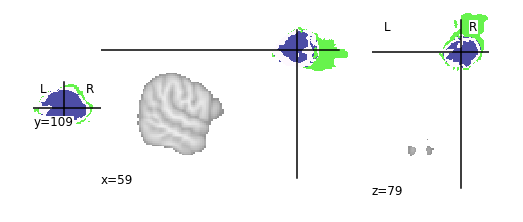

In [173]:
# Visualization
import nibabel
a = predict_best(t1_logits[0], t2_logits[0])
OUTPUT_AFFINE = np.array(
                [[0, 0, 1, 0],
                [0, 1, 0, 0],
                [1, 0, 0, 0],
                [0, 0, 0, 1]])
img = nibabel.Nifti1Image(t1_evals[0], OUTPUT_AFFINE)
print(t1_seg_pred.affine)
plotting.plot_roi(img) # brain data
seg_t1 = np.argmax(t1_logits[0],axis=-1)
seg_t2 = np.argmax(t2_logits[0],axis=-1)
seg_img_t1 = nibabel.Nifti1Image(seg_t1,OUTPUT_AFFINE)
seg_img_t2 = nibabel.Nifti1Image(seg_t1,OUTPUT_AFFINE)
plotting.plot_roi(seg_img_t1) # brain data
plotting.plot_roi(seg_img_t2)
